<a href="https://colab.research.google.com/github/fgith/data-science/blob/main/kaggle/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
! wget "https://raw.githubusercontent.com/fgith/data-science/main/datasets/healthcare-dataset-stroke-data.csv"

--2022-05-26 14:31:54--  https://raw.githubusercontent.com/fgith/data-science/main/datasets/healthcare-dataset-stroke-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘healthcare-dataset-stroke-data.csv’

healthcare-dataset- 100%[===================>] 309.54K  --.-KB/s    in 0.02s   

2022-05-26 14:31:55 (14.4 MB/s) - ‘healthcare-dataset-stroke-data.csv’ saved [316971/316971]



# **1. Load Data**

In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **2. Explore Data**

In [4]:
print('----------Dataset Shape----------')
print('No of Rows: ', df.shape[0],'| No of Columns: ',df.shape[1])
print('Columns:', df.columns.tolist())
print('---------------------------------')
print('----Column-wise unique values----')
cols = ['gender','hypertension','ever_married','work_type','Residence_type','smoking_status','stroke','heart_disease']
for i in range(len(cols)):
  print(cols[i],": ",df[cols[i]].unique().tolist())
print('---------------------------------')
print('-----Column-wise Nulls Dtype-----')
print(df.info())
print('---------------------------------')
print("No of Null values in column \'bmi':",df.bmi.isna().sum())

----------Dataset Shape----------
No of Rows:  5110 | No of Columns:  12
Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
---------------------------------
----Column-wise unique values----
gender :  ['Male', 'Female', 'Other']
hypertension :  [0, 1]
ever_married :  ['Yes', 'No']
work_type :  ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Residence_type :  ['Urban', 'Rural']
smoking_status :  ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
stroke :  [1, 0]
heart_disease :  [1, 0]
---------------------------------
-----Column-wise Nulls Dtype-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   objec

**Observations:**
* Column 'bmi' has 201 Null values. These need to be imputed later in the code
* Columns 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status' have Dtype Object/String. These need to be transformed into numerical values later in the code

**Let's do the following:**
*   Drop un-needed column 'id'

In [5]:
# Drop column 'id'
df.drop('id', axis=1, inplace = True)
df = df.reset_index(drop = True)

In [6]:
# function to print unique value counts in columns of a dataframe
def unique_col_counts(df, columns):
  for i in range(len(columns)):
    print(df[columns[i]].value_counts(),"\n")

# Check unique value counts in columns
columns = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','stroke']
unique_col_counts(df, columns)

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 

0    4612
1     498
Name: hypertension, dtype: int64 

0    4834
1     276
Name: heart_disease, dtype: int64 

Yes    3353
No     1757
Name: ever_married, dtype: int64 

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 

0    4861
1     249
Name: stroke, dtype: int64 



**Observations:**

*   'gender' has 1 row as 'Other'. The rest are either 'Female' or 'Male'. This row can be dropped without any significant impact
*   'work_type' has several categories. These will be generalized and numerical encoded later in code
*   'smoking_status' has several categories. These will be generalized and numerical encoded later in code
*   'ever_married' and 'Residence_type' have string values. These will be numerical binary encoded later in code

**Next:**

*   Drop 1 row with 'gender' value 'Other'

In [7]:
# Display row with 'gender' is 'Other'
display(df[df['gender'] == 'Other'])

# Drop row
df.drop(df.index[df['gender'] == 'Other'], inplace=True)

# Reset index of dataframe
df = df.reset_index(drop = True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


# **3. Data Preprocessing**

**3.1 Outlier Removal**

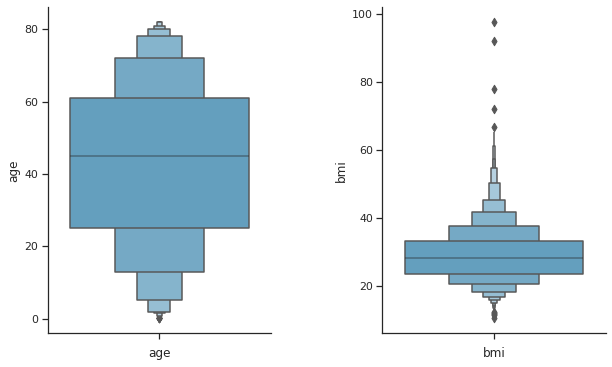

In [8]:
# Find outliers in the contiguos numeric data columns 'age', 'bmi'
sns.set_theme(style="ticks", palette="icefire")

cols = ['age','bmi']

fig, ax = plt.subplots(ncols=len(cols), figsize=(5 * len(cols),6), sharex = True)

for i in range(len(cols)):
  (sns.boxenplot(y=df[cols[i]],data=df, showfliers=True,ax=ax[i])).set(xlabel=cols[i])

fig.subplots_adjust(wspace=0.5)
sns.despine()

**Observations:**

*   'bmi' has outlier values > 80. These can be deleted


**Next:**

*   Drop rows with 'bmi' > 80

In [9]:
# Display rows with 'bmi' > 80
display(df[df['bmi'] > 80])

# Drop rows
df.drop(df.index[df['bmi'] > 80], inplace=True)

# Reset index of dataframe
df = df.reset_index(drop = True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4208,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


**3.2 Data Transformation**

In [10]:
# Replace values in 'work_type' with new generalized values
new_work_type ={'Private' : 'Work',
                 'Self-employed' : 'Work',
                 'children': 'No Work',
                 'Govt_job' : 'Work',
                 'Never_worked' : 'No Work'
                }
df['work_type'].replace(new_work_type, inplace = True)

# Replace values in 'smoking_status' with new generalized values
new_smoking_status ={'smokes' : 'Yes',
                      'never smoked' : 'No',
                      'Unknown' : 'No',
                      'formerly smoked': 'No'
                     }
df['smoking_status'].replace(new_smoking_status, inplace = True)

# Check the newly assigned values and counts
columns = ['work_type','smoking_status']
unique_col_counts(df, columns)

Work       4398
No Work     709
Name: work_type, dtype: int64 

No     4318
Yes     789
Name: smoking_status, dtype: int64 



**3.3 Encoding Categorical Features with One-Hot Encoder**

In [11]:
# The categorical columns are nominal and will be encoded using one-hoe encoder
# 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'

one_hot_encoder = OneHotEncoder()
df_temp = one_hot_encoder.fit_transform(df[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]).toarray()

encodings = pd.DataFrame(columns = one_hot_encoder.get_feature_names_out(), 
                         data = df_temp)
encodings = encodings.astype(int)
df = pd.concat([df,encodings] , axis=1)

df.drop(['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'],axis = 1, inplace=True)
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_No Work,work_type_Work,Residence_type_Rural,Residence_type_Urban,smoking_status_No,smoking_status_Yes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,1,1,0
1,61.0,0,0,202.21,NaN,1,1,0,0,1,0,1,1,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,1,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,1,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,1,0,1,1,0,1,0


**3.4 Missing values Imputation**

In [12]:
# As observed earlier, 'bmi' has Null values. Calculate percentage of missing values
print("Percentage of missing values in bmi: ", round(100*df['bmi'].isna().sum()/df['bmi'].count(),2),"%")

# We will use mode of 'bmi' and assign to missing values
bmi_mode = df['bmi'].mode()
df = df.fillna({'bmi' : bmi_mode[0]})

# Check to see there are no more missing values
df.isna().sum()

Percentage of missing values in bmi:  4.1 %


age                     0
hypertension            0
heart_disease           0
avg_glucose_level       0
bmi                     0
stroke                  0
gender_Female           0
gender_Male             0
ever_married_No         0
ever_married_Yes        0
work_type_No Work       0
work_type_Work          0
Residence_type_Rural    0
Residence_type_Urban    0
smoking_status_No       0
smoking_status_Yes      0
dtype: int64

**3.5 Feature Scaling**

In [13]:
# Divide dataset into X feature variables and target variable y
X = df.drop(['stroke'],axis=1)
y = df['stroke'].to_frame()

In [14]:
# Apply Standard Scaler to entire dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_No Work,work_type_Work,Residence_type_Rural,Residence_type_Urban,smoking_status_No,smoking_status_Yes
0,1.050908,-0.327977,4.183733,2.706084,1.019950,-1.190354,1.190354,-0.72358,0.72358,-0.401509,0.401509,-0.983492,0.983492,0.427462,-0.427462
1,0.785570,-0.327977,-0.239021,2.121277,-0.021231,0.840086,-0.840086,-0.72358,0.72358,-0.401509,0.401509,1.016785,-1.016785,0.427462,-0.427462
2,1.625806,-0.327977,4.183733,-0.005273,0.479590,-1.190354,1.190354,-0.72358,0.72358,-0.401509,0.401509,1.016785,-1.016785,0.427462,-0.427462
3,0.254895,-0.327977,-0.239021,1.437089,0.730001,0.840086,-0.840086,-0.72358,0.72358,-0.401509,0.401509,-0.983492,0.983492,-2.339391,2.339391
4,1.581583,3.048995,-0.239021,1.500914,-0.640668,0.840086,-0.840086,-0.72358,0.72358,-0.401509,0.401509,1.016785,-1.016785,0.427462,-0.427462


# **4. Dimensionality Reduction**

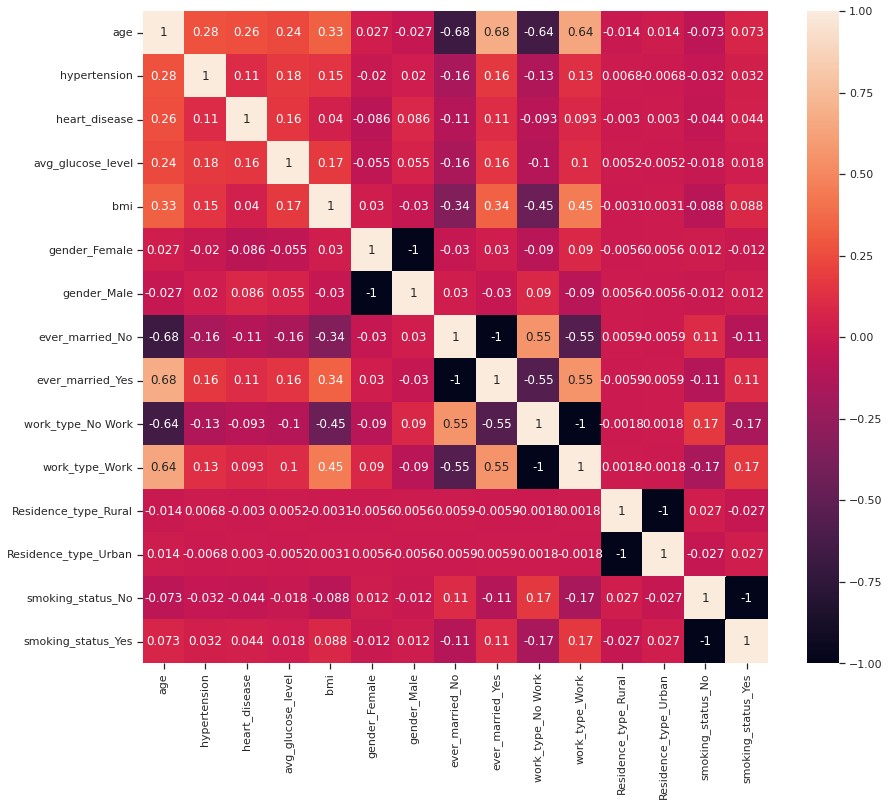

In [15]:
#  Plot Heatmap to identify correlated features
fig = plt.figure(figsize=(14,12))         
sns.heatmap(X.corr(), annot = True)

**Observations:**

There are several correalted features as we performed encoding on categorical features.

**Next:**

Double-check correlated features using a function and delete them from dataset

In [16]:
# Function to select highly correlated features

def correlation(dataset, threshold):
    col_corr = set()  # Set of names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # absolute coeff value to account for -ve correlation
                colname = corr_matrix.columns[i]  # get name of column
                col_corr.add(colname)
    return col_corr
corr_features = correlation(df, 0.75)
print(len(set(corr_features)), " ", corr_features)

5   {'gender_Male', 'Residence_type_Urban', 'ever_married_Yes', 'work_type_Work', 'smoking_status_Yes'}


In [17]:
# Drop correlated features returned by the function from dataset
X = X.drop(corr_features,axis=1)
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,ever_married_No,work_type_No Work,Residence_type_Rural,smoking_status_No
0,67.0,0,1,228.69,36.6,0,0,0,0,1
1,61.0,0,0,202.21,28.7,1,0,0,1,1
2,80.0,0,1,105.92,32.5,0,0,0,1,1
3,49.0,0,0,171.23,34.4,1,0,0,0,0
4,79.0,1,0,174.12,24.0,1,0,0,1,1


# **5. Model Training and Prediction**

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state=0)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=20)
log_clf = LogisticRegression(max_iter=1000)
svc_clf = SVC(probability=True)

In [21]:
voting_clf = VotingClassifier(estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svc_clf)],voting='hard')
voting_clf.fit(X_train,np.ravel(y_train))
y_pred = voting_clf.predict(X_test)

In [22]:
# Check accuracy of the Regressors using K-Fold evaluation
for clf, label in zip([rnd_clf, log_clf, svc_clf, voting_clf], ['Random Forest Classifier', 'Logistic Regression Classifier', 'SVC Classifier','Voting Classifier']):
  scores = cross_val_score(clf, X, np.ravel(y), scoring='accuracy', cv=10)
  print("Accuracy: %0.2f [%s]" % (scores.mean(), label))
  # print(scores)

Accuracy: 0.95 [Random Forest Classifier]
Accuracy: 0.95 [Logistic Regression Classifier]
Accuracy: 0.95 [SVC Classifier]
Accuracy: 0.95 [Voting Classifier]


In [23]:
params = { 'penalty' : ['l1','l2','elasticnet'],
          'C' : np.logspace(-4, 4, 20),
          'solver' : ['lbfgs', 'liblinear'],
          'max_iter' : [1000,2000,3000,4000] 
         }
grid = GridSearchCV(log_clf, params)
grid.fit(X, np.ravel(y))
grid.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1200 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: S

{'C': 0.23357214690901212,
 'max_iter': 1000,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [ ]:
params = { 'voting' : ['hard','soft'],
          'weights' : [(1,1,2),(2,1,1),(1,2,1)]
}
grid = GridSearchCV(voting_clf, params)
grid.fit(X, np.ravel(y))
grid.best_params_

{'voting': 'hard', 'weights': (1, 1, 2)}

In [ ]:
grid.best_score_

0.9451554280248684

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svc_clf,voting_clf):
  clf.fit(X_train,np.ravel(y_train))
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.9527655408712677
RandomForestClassifier 0.9500734214390602
SVC 0.9527655408712677
VotingClassifier 0.9527655408712677
